In [14]:
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import numpy as np

In [15]:
binary_policy = tfp.distributions.Bernoulli(probs=0.5)
for i in range(5):
    action = binary_policy.sample(1)
    print("Action: ",action)

Action:  tf.Tensor([0], shape=(1,), dtype=int32)
Action:  tf.Tensor([1], shape=(1,), dtype=int32)
Action:  tf.Tensor([1], shape=(1,), dtype=int32)
Action:  tf.Tensor([0], shape=(1,), dtype=int32)
Action:  tf.Tensor([0], shape=(1,), dtype=int32)


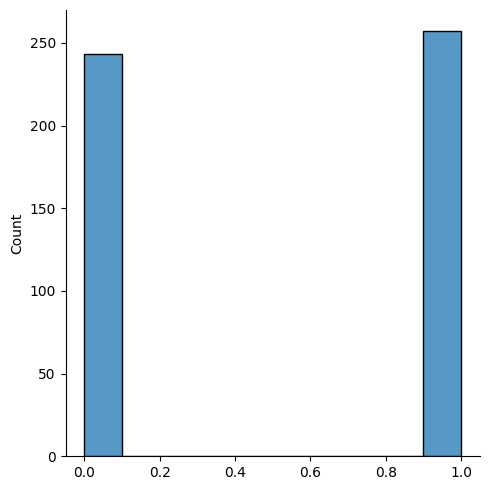

In [16]:
# Sample 500 actions from the binary policy distribution
sample_actions = binary_policy.sample(500)
sns.displot(sample_actions)

In [17]:
action_dim = 4 # Dimension of the discrete action space
action_probabilities = [0.7, 0.1, 0.1, 0.1]
discrete_policy = tfp.distributions.Multinomial(probs=action_probabilities, total_count=1)
for i in range(5):
    action = discrete_policy.sample(1)
    print(action)

tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[1. 0. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[1. 0. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[1. 0. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[1. 0. 0. 0.]], shape=(1, 4), dtype=float32)


<Axes: ylabel='Count'>

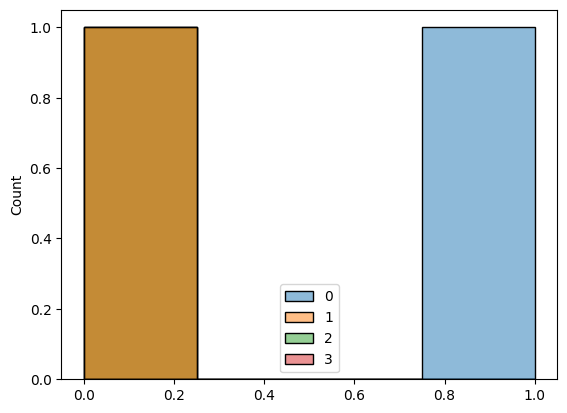

In [18]:
sns.histplot(discrete_policy.sample(1))

In [19]:
def entropy(action_probs):
    return -tf.reduce_sum(action_probs * tf.math.log(action_probs), axis=-1)
action_probabilities = [0.25, 0.25, 0.25, 0.25]
print(entropy(action_probabilities))

tf.Tensor(1.3862944, shape=(), dtype=float32)


In [20]:
class DiscretePolicy(object):
    def __init__(self, num_actions):
        self.action_dim = num_actions
    def sample(self, action_logits):
        self.distribution = tfp.distributions.Multinomial(logits=action_logits, total_count=1)
        return self.distribution.sample(1)

    def get_action(self, action_logits):
        action = self.sample(action_logits)
        return np.where(action)[-1]
    # Return the action index
    def entropy(self, action_probabilities):
        return -tf.reduce_sum(action_probabilities * tf.math.log(action_probabilities), axis=-1)
    

def evaluate(agent, env, render=True):
    obs, episode_reward, done, step_num = env.reset(),0.0, False, 0

    while not done:
        action = agent.get_action(obs)
        obs, reward, done, info = env.step(action)
        episode_reward += reward
        step_num += 1
        if render:
            env.render()
    return step_num, episode_reward, done, info

class Brain(keras.Model):
    def __init__(self, action_dim=5,input_shape=(1, 8 * 8)):
        """Initialize the Agent's Brain model
        Args:
        action_dim (int): Number of actions
        """
        super(Brain, self).__init__()
        self.dense1 = layers.Dense(32, input_shape=input_shape, activation="relu")
        self.logits = layers.Dense(action_dim)
    
    def call(self, inputs):
        x = tf.convert_to_tensor(inputs)
        if len(x.shape) >= 2 and x.shape[0] != 1:
            x = tf.reshape(x, (1, -1))
        return self.logits(self.dense1(x))
    
    def process(self, observations):
        # Process batch observations using `call(inputs)` behindthe-scenes
        action_logits = self.predict_on_batch(observations)
        return action_logits
        

class Agent(object):
    def __init__(self, action_dim=5, input_dim=(1, 8 * 8)):
        self.brain = Brain(action_dim, input_dim)
        self.policy = DiscretePolicy(action_dim)
        
    def get_action(self, obs):
        action_logits = self.brain.process(obs)
        action = self.policy.get_action(np.squeeze(action_logits, 0))
        return action

In [21]:
from ipynb.fs.full.GridWorldEnv import GridworldEnv
env = GridworldEnv()
agent = Agent(env.action_space.n,env.observation_space.shape)
steps, reward, done, info = evaluate(agent, env)
print(f"steps:{steps} reward:{reward} done:{done} info:{info}")
env.close()

steps:2514 reward:-94.69999999999895 done:True info:{'success': True}


In [22]:
print(env.observation_space.shape)

(8, 8)
